In [1]:
import torch 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt 
from torch.func import vmap, grad
from tqdm import tqdm
from scipy.stats import binned_statistic_2d

from score_models import ScoreModel

import json

plt.style.use("dark_background")
sys.path.append("..\\scripts\\")
from utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"

# Importing the models hparams and weights
file = open("../../ncsnpp_probes_g_64_230604024652/model_hparams.json")
model_hparams = json.load(file)
sigma_min, sigma_max = model_hparams["sigma_min"], model_hparams["sigma_max"]

# Importing the weights
score_model = ScoreModel(checkpoints_directory="../../ncsnpp_probes_g_64_230604024652")

def preprocess_probes_g_channel(img, inv_link = False):  # channel 0
    img = torch.clamp(img, 0, 1.48)
    
    if inv_link:
        img = 2 * img / 1.48 - 1.
    return img

def link_function(x):
    return (x + 1)/2

def ft(x): 
    return torch.fft.fft2(x, norm = "ortho")

def ift(x): 
    return torch.fft.ifft2(x, norm = "ortho")
    
from mpol import coordinates
from mpol.gridding import DirtyImager

plt.style.use("dark_background")

from utils import fits_to_tensor, link_function
device = "cuda" if torch.cuda.is_available() else "cpu"



In [3]:
beam = torch.tensor(torch.load("beam64.pt")).to(device)


fits_file_path = 'HTLup_continuum0.0015arcsec2_psf.fits'

header, psf = fits_to_tensor("../../"+ fits_file_path)
psf = resize(psf, target_size=64).to(device)


In [2]:
sys.path.append("../../")
from uv_coverage import sim_uv_cov
h = 1 # hours
grid, noise_rms, u, v, ants1, ants2 = sim_uv_cov(h)
uv = torch.tensor(np.array([u, v]).transpose()).to(device)

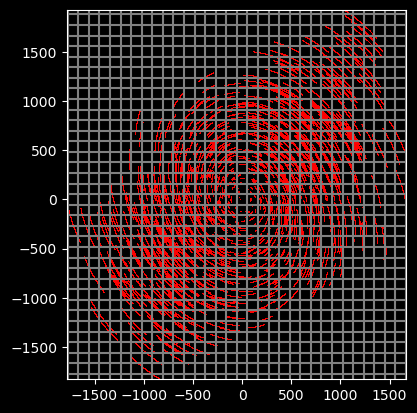

In [3]:
pixel_scale = 0.015 # arcsec
npix = 128 # Number of pixels in the grid
coords = coordinates.GridCoords(cell_size=pixel_scale, npix=npix)

plt.scatter(u, v, s=0.5, rasterized=True, linewidths=0.0, c="r")
for x_coord in coords.u_edges: 
    plt.axvline(x = x_coord, color = "gray", linestyle = "-")

for y_coord in coords.v_edges:
    plt.axhline(y =y_coord, color = "gray", linestyle = "-")

plt.xlim([u.min(), u.max()])
plt.ylim([v.min(), v.max()])
plt.gca().set_aspect("equal")

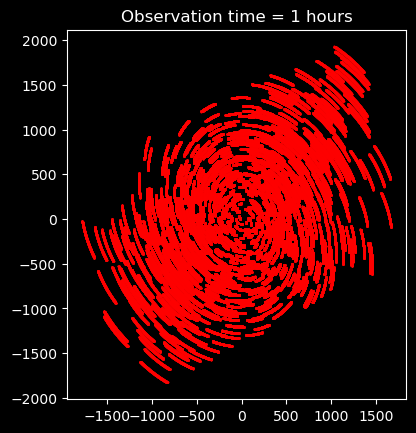

In [24]:
plt.plot(u, v, '.r', markersize=1)
plt.title(f"Observation time = {h} hours")
plt.gca().set_aspect("equal")
plt.show()

c:\Users\noedi\Desktop\Ciela Research\ML code\interferometry\diffusion-radio-astronomy\notebooks\..\scripts\utils.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(dataset[idx, ..., 1])


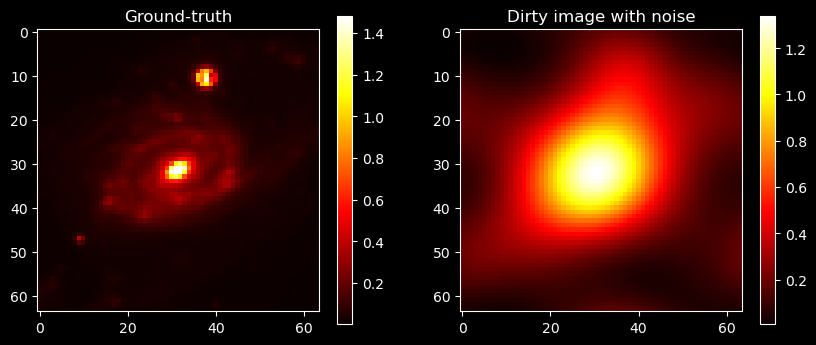

In [12]:
dataset = torch.load("../../true_prior.pt")
k = 74

img = probes_64(dataset, k).to(device)
img_size = img.shape[-1]

vis_full = ft(img).flatten()

beam = torch.tensor(torch.load("beam64.pt")).mean(axis = 0).to(device)
sampling_function= ft(torch.fft.ifftshift(beam)).flatten()
vis_sampled = sampling_function * vis_full

sigma_likelihood = 1e-4
vis_sampled = vis_sampled.flatten()


D = len(vis_sampled)  

eta = sigma_likelihood * torch.randn(D).to(device) + 1j * sigma_likelihood * torch.randn(D).to(device)

y = vis_sampled + eta 


# PLOTS##################
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
dirty_image_noise = ift((y).reshape(img_size, img_size)).real


im = axs[0].imshow(img.reshape(img_size, img_size).cpu(), cmap = "hot")
axs[0].set_title("Ground-truth")
plt.colorbar(im)
im = axs[1].imshow(dirty_image_noise.cpu(), cmap = "hot")
axs[1].set_title("Dirty image with noise")
plt.colorbar(im)


In [ ]:
sampling_function = 

In [21]:
beta = 0
def sigma(t): 
    return sigma_min * (sigma_max/sigma_min) ** t


def model(x):
    x = link_function(x)
    vis_full = ft(x.reshape(img_size, img_size)).flatten()
    vis_sampled = sampling_function * vis_full

    #vis_sampled = S @ vis_full
    return vis_sampled

S = sampling_function

def logprob_likelihood(x, sigmas): 
    """Calculate the log-likelihood of a Multivariate Gaussian for a diagonal covariance matrix

    Args:
        x: point where we want to compute the log-likelihood
        sigmas: Tensor containing the elements of the diagonal of the covariance matrix 

    Returns:
        log-likelihood
    """

    D = x.shape[-1]
    val = - (x.conj().t() * 1/sigmas ) @ x # - D/2 * np.log(2*np.pi) - 1/2 * torch.log(torch.prod(sigmas))
    return val.squeeze(0)


# GIVE THE GOOD COVARIANCE MATRIX
def score_likelihood(x, t): 
    I = torch.ones(D).to(device)
    return vmap(grad(lambda x, t: logprob_likelihood(y -model(x), sigma_likelihood ** 2 * I + sigma_likelihood**2 *1j * I + sigma(t)**2 * S.abs()**2 )))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    return score_model.score(t, x.reshape(-1, 1, img_size, img_size)).flatten(start_dim = 1) + score_likelihood(x, t)

x = torch.randn([1, img_size ** 2]).to(device) 
t = torch.ones([1]).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_posterior(x, t))
#score_model.score(t, x.reshape(-1, 1, img_size, img_size)).shape 

tensor(0.0003, device='cuda:0')
tensor([[ 3.7028e-03, -1.8555e-03, -3.3845e-03,  ..., -1.9367e-03,
          3.7980e-03, -4.3662e-05]], device='cuda:0', grad_fn=<AddBackward0>)


In [22]:
def g(t): 
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
            
    return link_function(x_mean)

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = sigma_max * torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            drift = 0
            diffusion = g(t)
            x_mean = x - diffusion**2 * gradient * dt  
            noise = diffusion * (-dt) ** 0.5 * z
            x = x_mean + noise
            t += dt

            #print(score_likelihood(x, t))
            if torch.any(torch.isnan(x_mean)):
                print("Nans appearing")
                break
    
    return link_function(x_mean) 

pred = 500
corr = 100
snr = 1e-2
samples = euler_sampler(num_samples = 1, num_steps = pred, score_function = score_posterior, img_size = img_size)
#samples = pc_sampler(num_samples = 4, num_pred_steps = pred, num_corr_steps = corr, snr = snr, score_function = score_posterior, img_size = img_size)

100%|██████████| 499/499 [00:23<00:00, 21.01it/s]


In [58]:
samples.max()

tensor(1.1632, device='cuda:0')

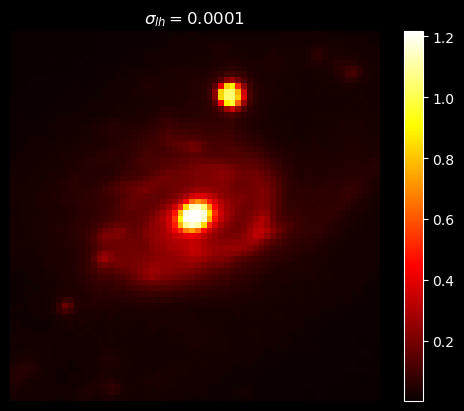

In [23]:
n_images = len(samples)

if n_images != 1:
    grid_size = int(n_images**0.5)
    fig, axs = plt.subplots(grid_size, grid_size, figsize = (8, 8))

    a = 0
    for i in range(grid_size):
        for j in range(grid_size): 
            axs[i, j].imshow(samples[a].cpu().reshape(img_size, img_size), cmap = "hot")
            axs[i, j].axis("off")
else: 
    plt.imshow(samples.cpu().reshape(img_size, img_size), cmap = "hot")
    plt.axis("off")
    plt.colorbar(fraction = 0.046)
    plt.title(r"$\sigma_{lh} = $" + f"{sigma_likelihood:1g}")